In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost
pd.options.display.max_rows = None
pd.options.display.max_columns = None
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Load data
# Loading data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.drop(["Id"],inplace=True,axis=1)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.tree import plot_tree


## Which numeric features have missing values? 

In [378]:
numeric_features = train.select_dtypes(exclude=["object"])
# Get a Boolean DataFrame indicating missing values
missing_values = numeric_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = numeric_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s).')

"MasVnrArea" has 8 missing value(s).
"GarageYrBlt" has 81 missing value(s).
"LotFrontage" has 259 missing value(s).


### We will define GarageYrBlt = NaN as 0, since the house dosen't have garage
### Same for LotFrontage and MasVnrArea as NaN means no linear feet of street connected to property


In [379]:
train.GarageYrBlt.fillna(0,inplace=True)
train.LotFrontage.fillna(0,inplace=True)
train.MasVnrArea.fillna(0,inplace=True)
numeric_features = train.drop(["SalePrice"],axis=1).select_dtypes(exclude=["object"])

## Cleaning missing values in categorical features

In [380]:
categorical_features = train.select_dtypes(include=["object"])
# Get a Boolean DataFrame indicating missing values
missing_values = categorical_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = categorical_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s).')


"Electrical" has 1 missing value(s).
"MasVnrType" has 8 missing value(s).
"BsmtQual" has 37 missing value(s).
"BsmtCond" has 37 missing value(s).
"BsmtFinType1" has 37 missing value(s).
"BsmtExposure" has 38 missing value(s).
"BsmtFinType2" has 38 missing value(s).
"GarageType" has 81 missing value(s).
"GarageFinish" has 81 missing value(s).
"GarageQual" has 81 missing value(s).
"GarageCond" has 81 missing value(s).
"FireplaceQu" has 690 missing value(s).
"Fence" has 1179 missing value(s).
"Alley" has 1369 missing value(s).
"MiscFeature" has 1406 missing value(s).
"PoolQC" has 1453 missing value(s).


### Electrical:  Missing was set to the mode of neighborhood its neighborhood

#### The remainings features  contain NaN values because they represent a qualitative measurement of a property that doesn't exist. For instance, if a row has a value of 0 for 'Fireplaces', then 'FireplaceQu' will also be NaN. To make it easier to work with the data later, I've converted all these NaN values to the string "Na".

In [381]:
# Electricity
most_common_in_neigh = categorical_features[(categorical_features['Neighborhood'] == categorical_features.loc[1379]['Neighborhood'])]["Electrical"].value_counts().index[0]
categorical_features.loc[1379, 'Electrical']  = most_common_in_neigh

## 'MasVnrType' , 'MasVnrArea'

# mask = categorical_features['MasVnrType'].isna()
# nan_rows = categorical_features[mask].index

# categorical_features.loc[nan_rows,'MasVnrType'] = "None"


## Remaining


# Get a Boolean DataFrame indicating missing values
missing_values = categorical_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = categorical_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for col in columns_with_missing_values: # columns related to garage and basement
    
    categorical_features[col].fillna("Na", inplace=True)


## Plotting Var for each categorical feature

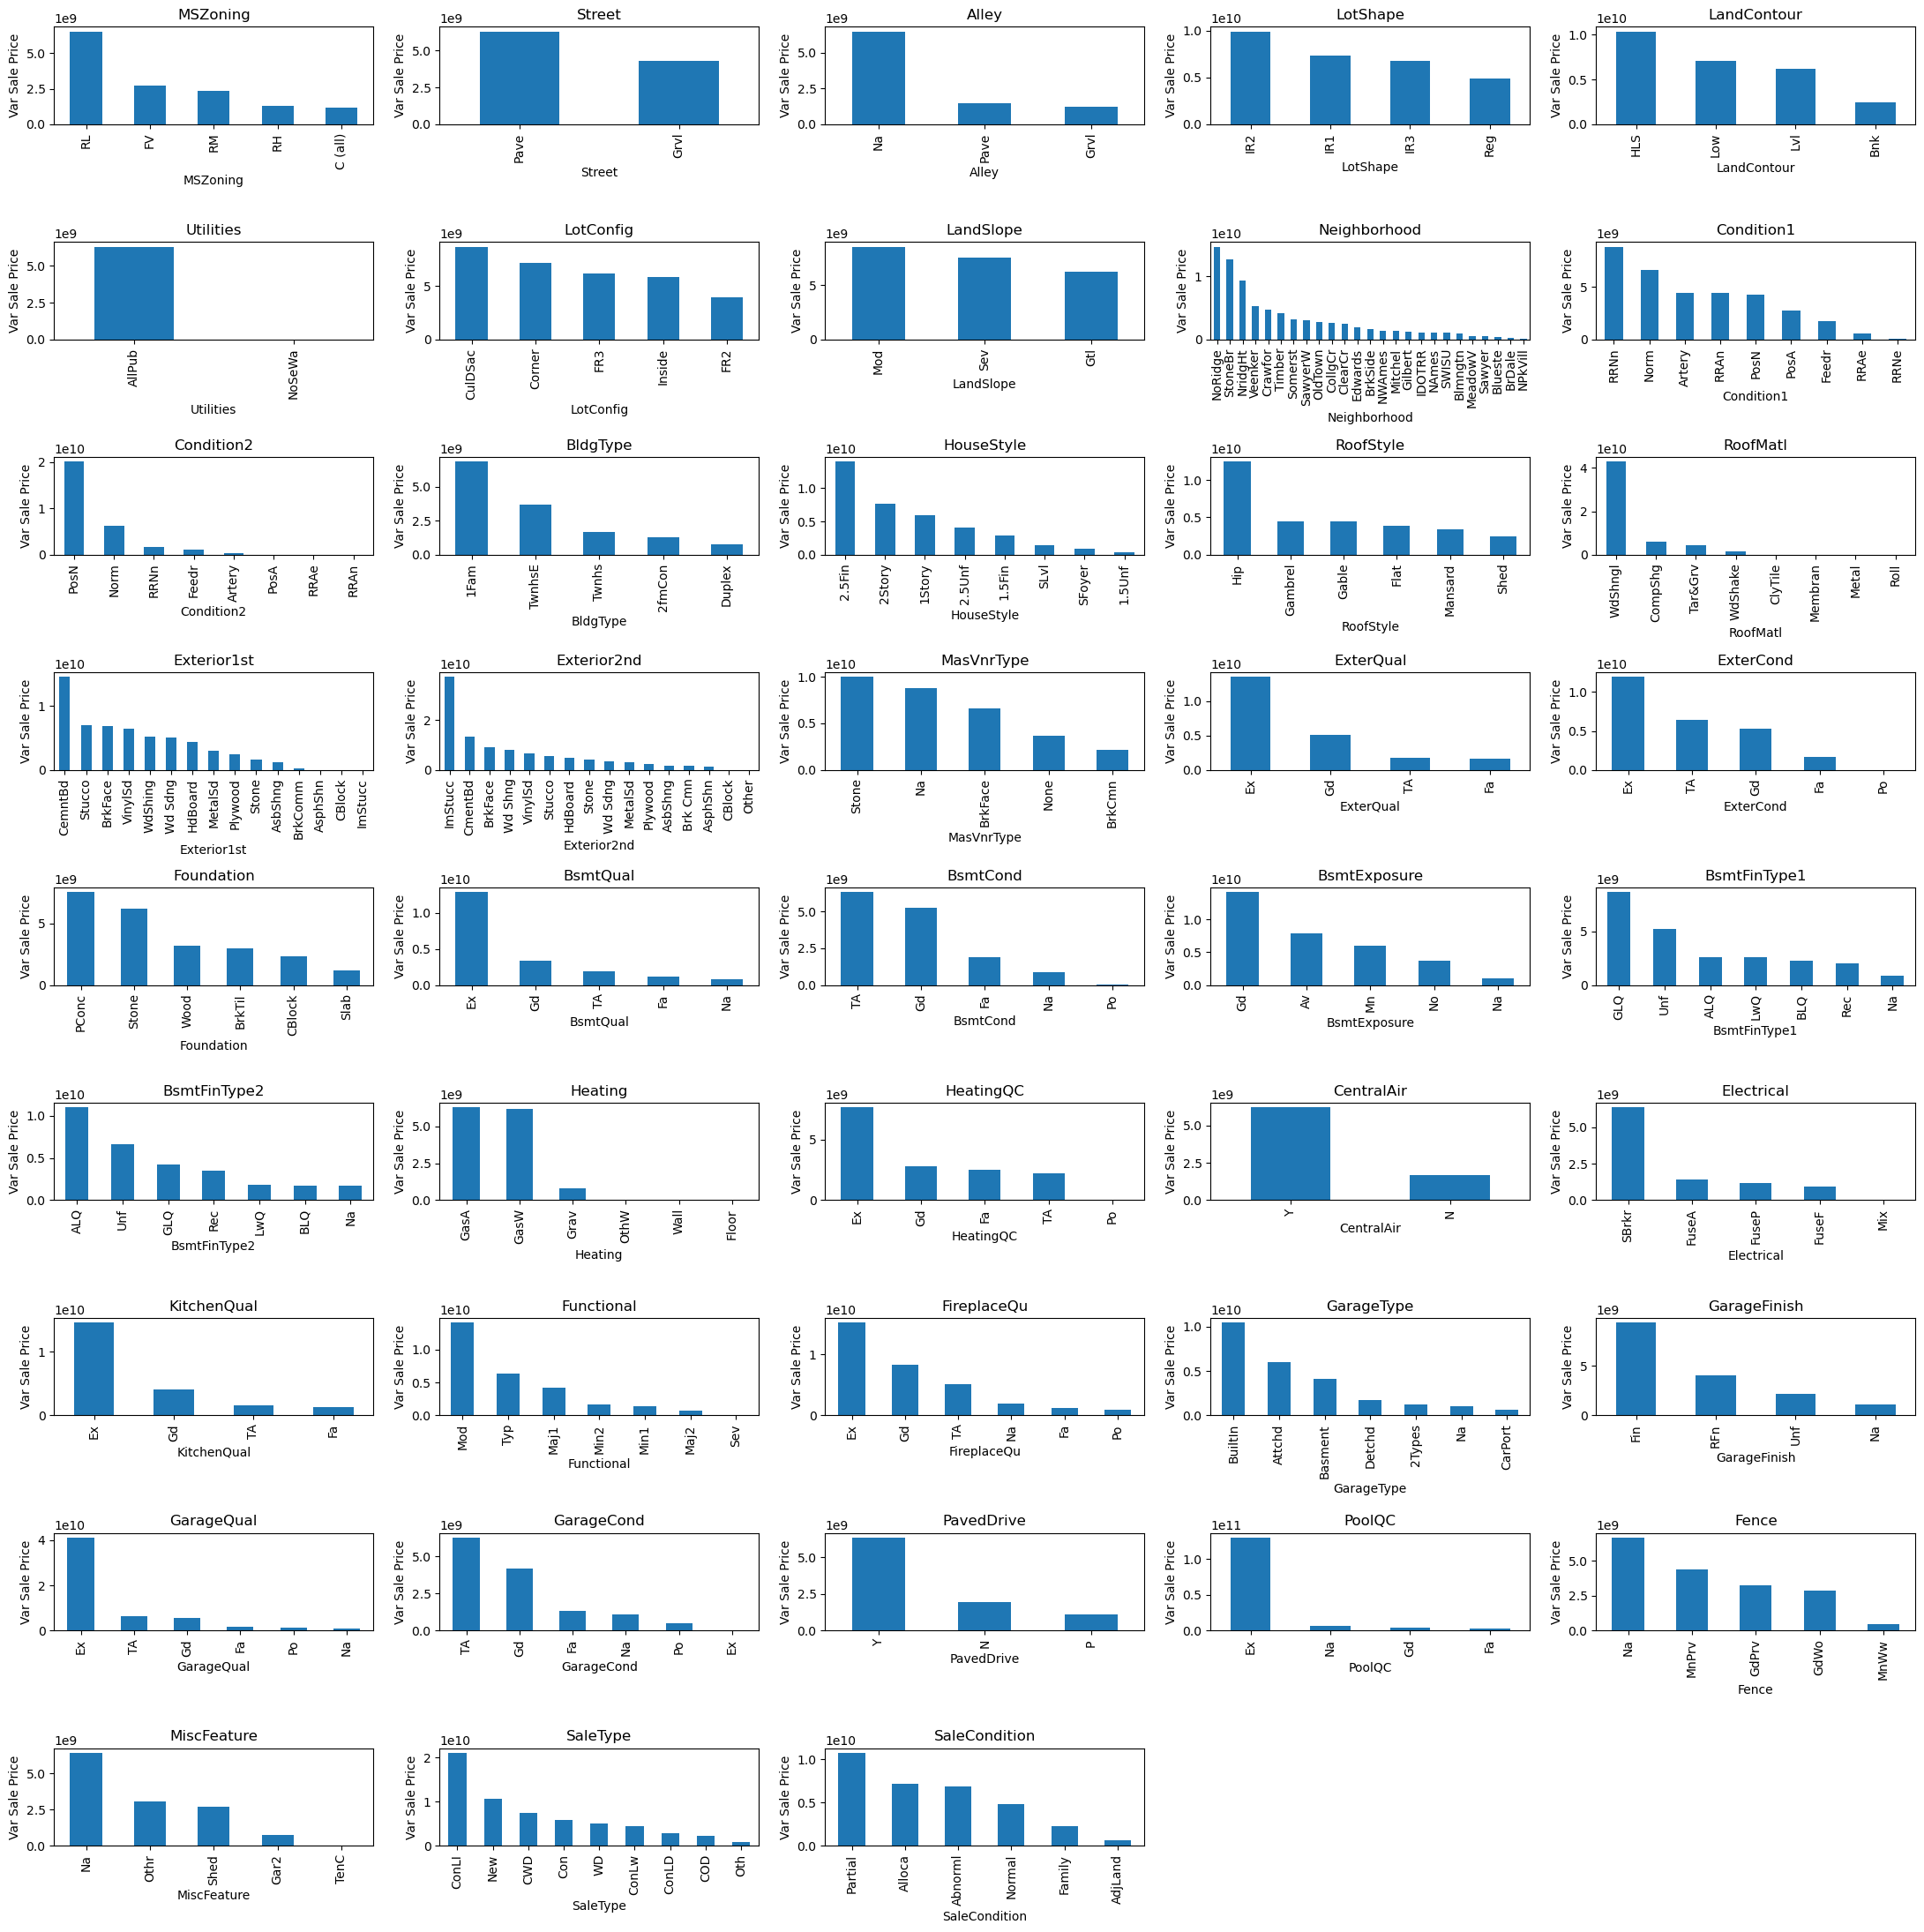

In [383]:

categorical_features["SalePrice"] = train["SalePrice"]
# Group the data by the "MSZoning" column and calculate the mean "SalePrice" value for each group
plt.figure(figsize = (22,22))
for i,col in enumerate(categorical_features.columns[:-1]):
    plt.subplot(9,5,i+1)
    mean_sale_price_by_zoning = categorical_features.groupby(col).var()["SalePrice"]

    # Sort the mean "SalePrice" values in descending order
    mean_sale_price_by_zoning = mean_sale_price_by_zoning.sort_values(ascending=False)

    # Plot the mean "SalePrice" value for each group
    mean_sale_price_by_zoning.plot.bar()

    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.ylabel("Var Sale Price")

    # Show the plot

plt.tight_layout()

## Plotting Mean for each categorical feature

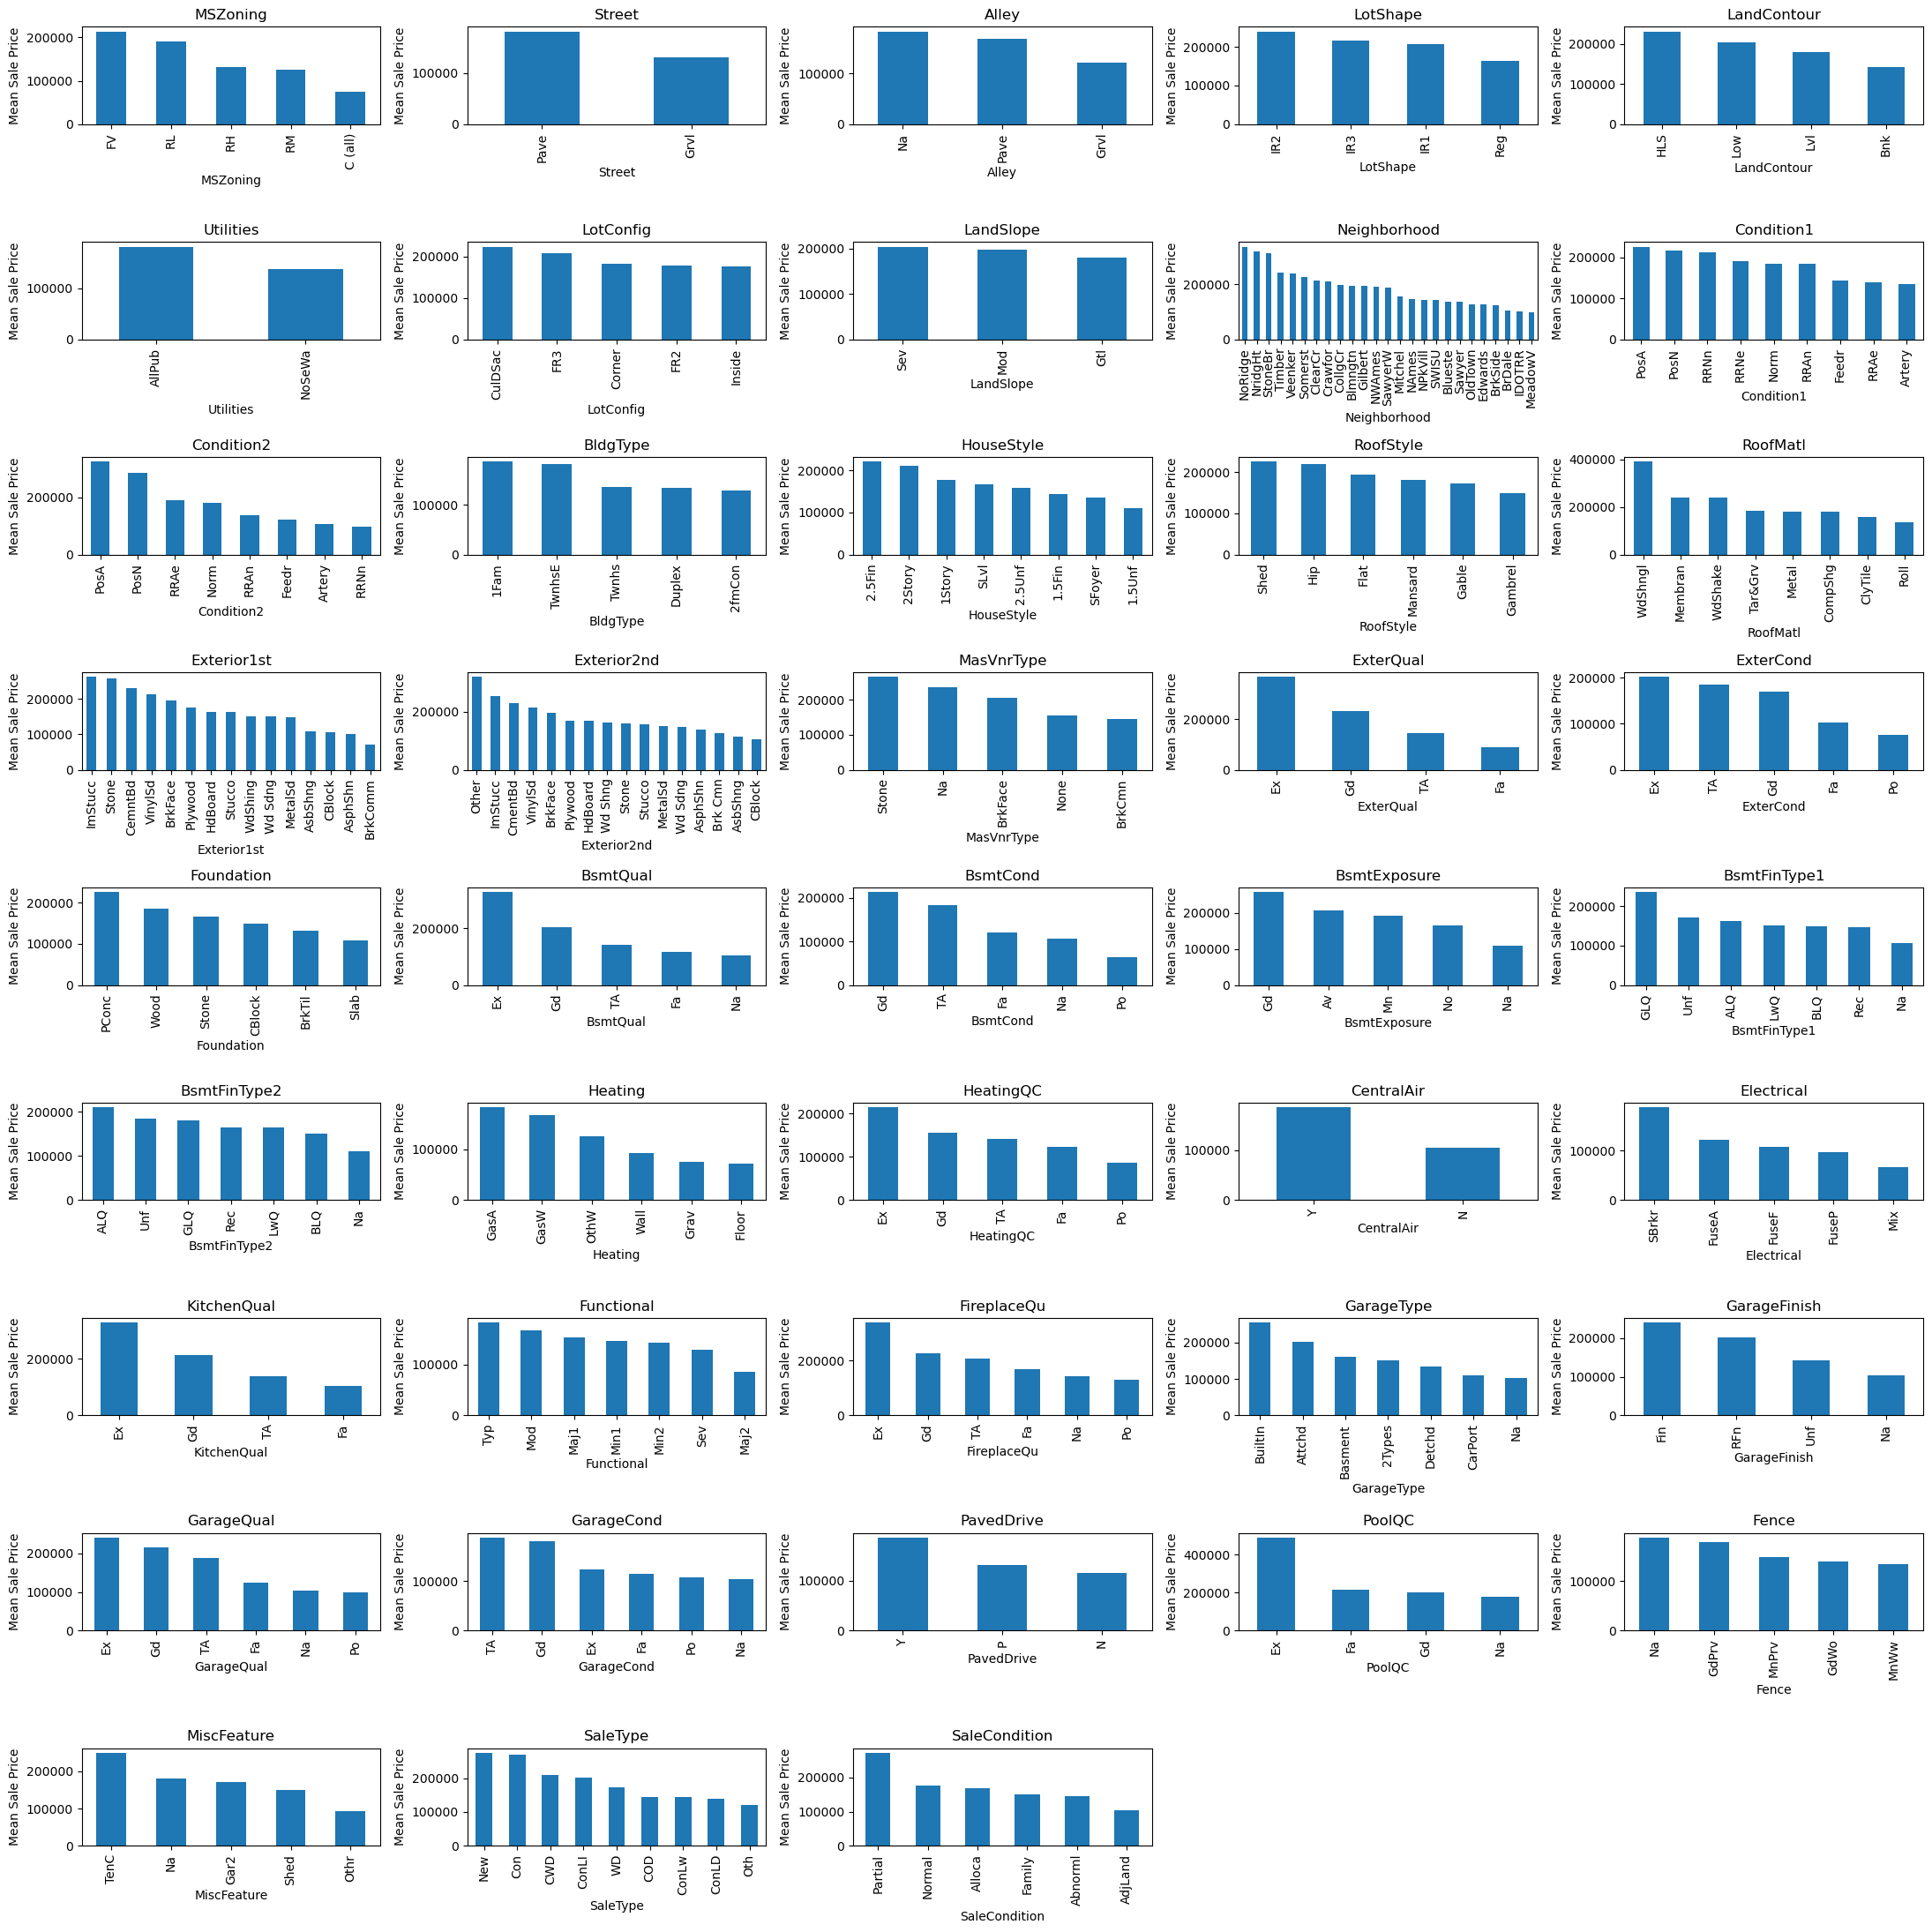

In [384]:
plt.figure(figsize = (22,22))
for i,col in enumerate(categorical_features.columns[:-1]):
    plt.subplot(9,5,i+1)
    mean_sale_price_by_zoning = categorical_features.groupby(col).mean()["SalePrice"]

    # Sort the mean "SalePrice" values in descending order
    mean_sale_price_by_zoning = mean_sale_price_by_zoning.sort_values(ascending=False)

    # Plot the mean "SalePrice" value for each group
    mean_sale_price_by_zoning.plot.bar()

    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.ylabel("Mean Sale Price")

    # Show the plot

plt.tight_layout()

## Count of categorical features

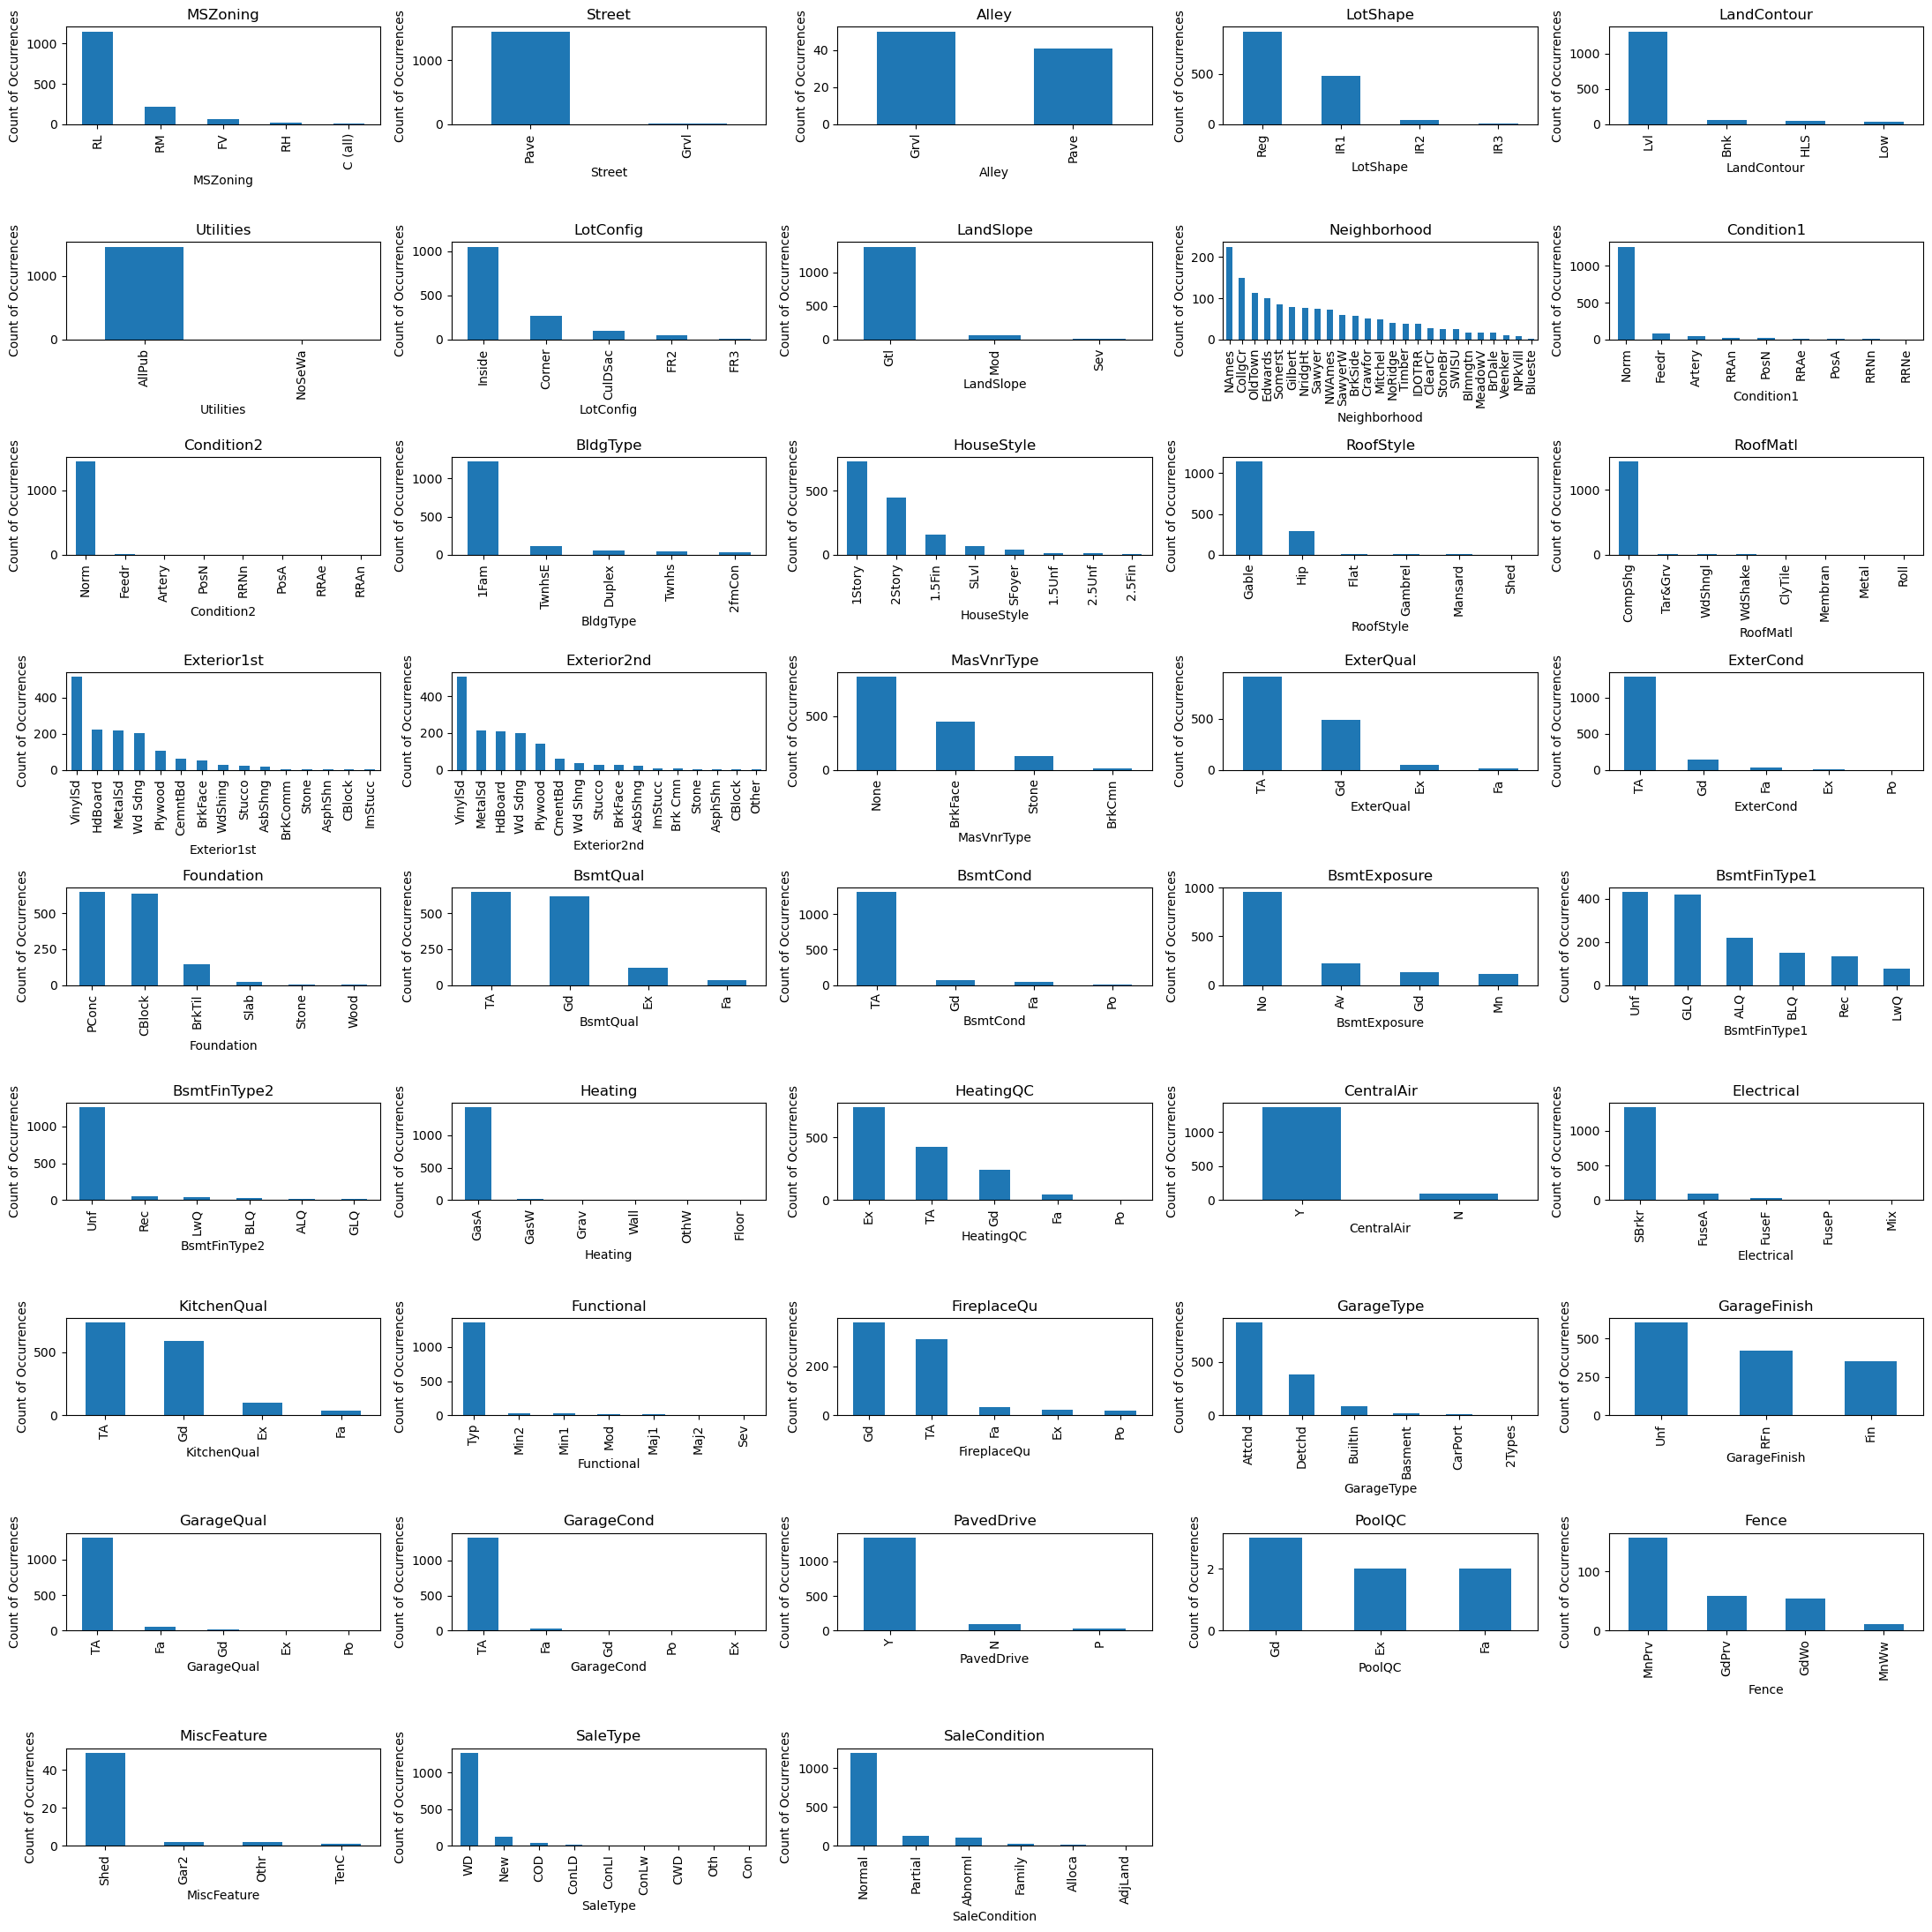

In [385]:


# Group the data by the "MSZoning" column and calculate the count of occurrences of each group
plt.figure(figsize = (22,22))
for i,col in enumerate(categorical_features.columns[:-1]):
    plt.subplot(9,5,i+1)
    count_by_zoning = train.groupby(col).size()

    # Sort the count of occurrences in descending order
    count_by_zoning = count_by_zoning.sort_values(ascending=False)

    # Plot the count of occurrences for each group
    count_by_zoning.plot.bar()

    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Count of Occurrences")

    # Show the plot

plt.tight_layout()


## Visualizing numeric data

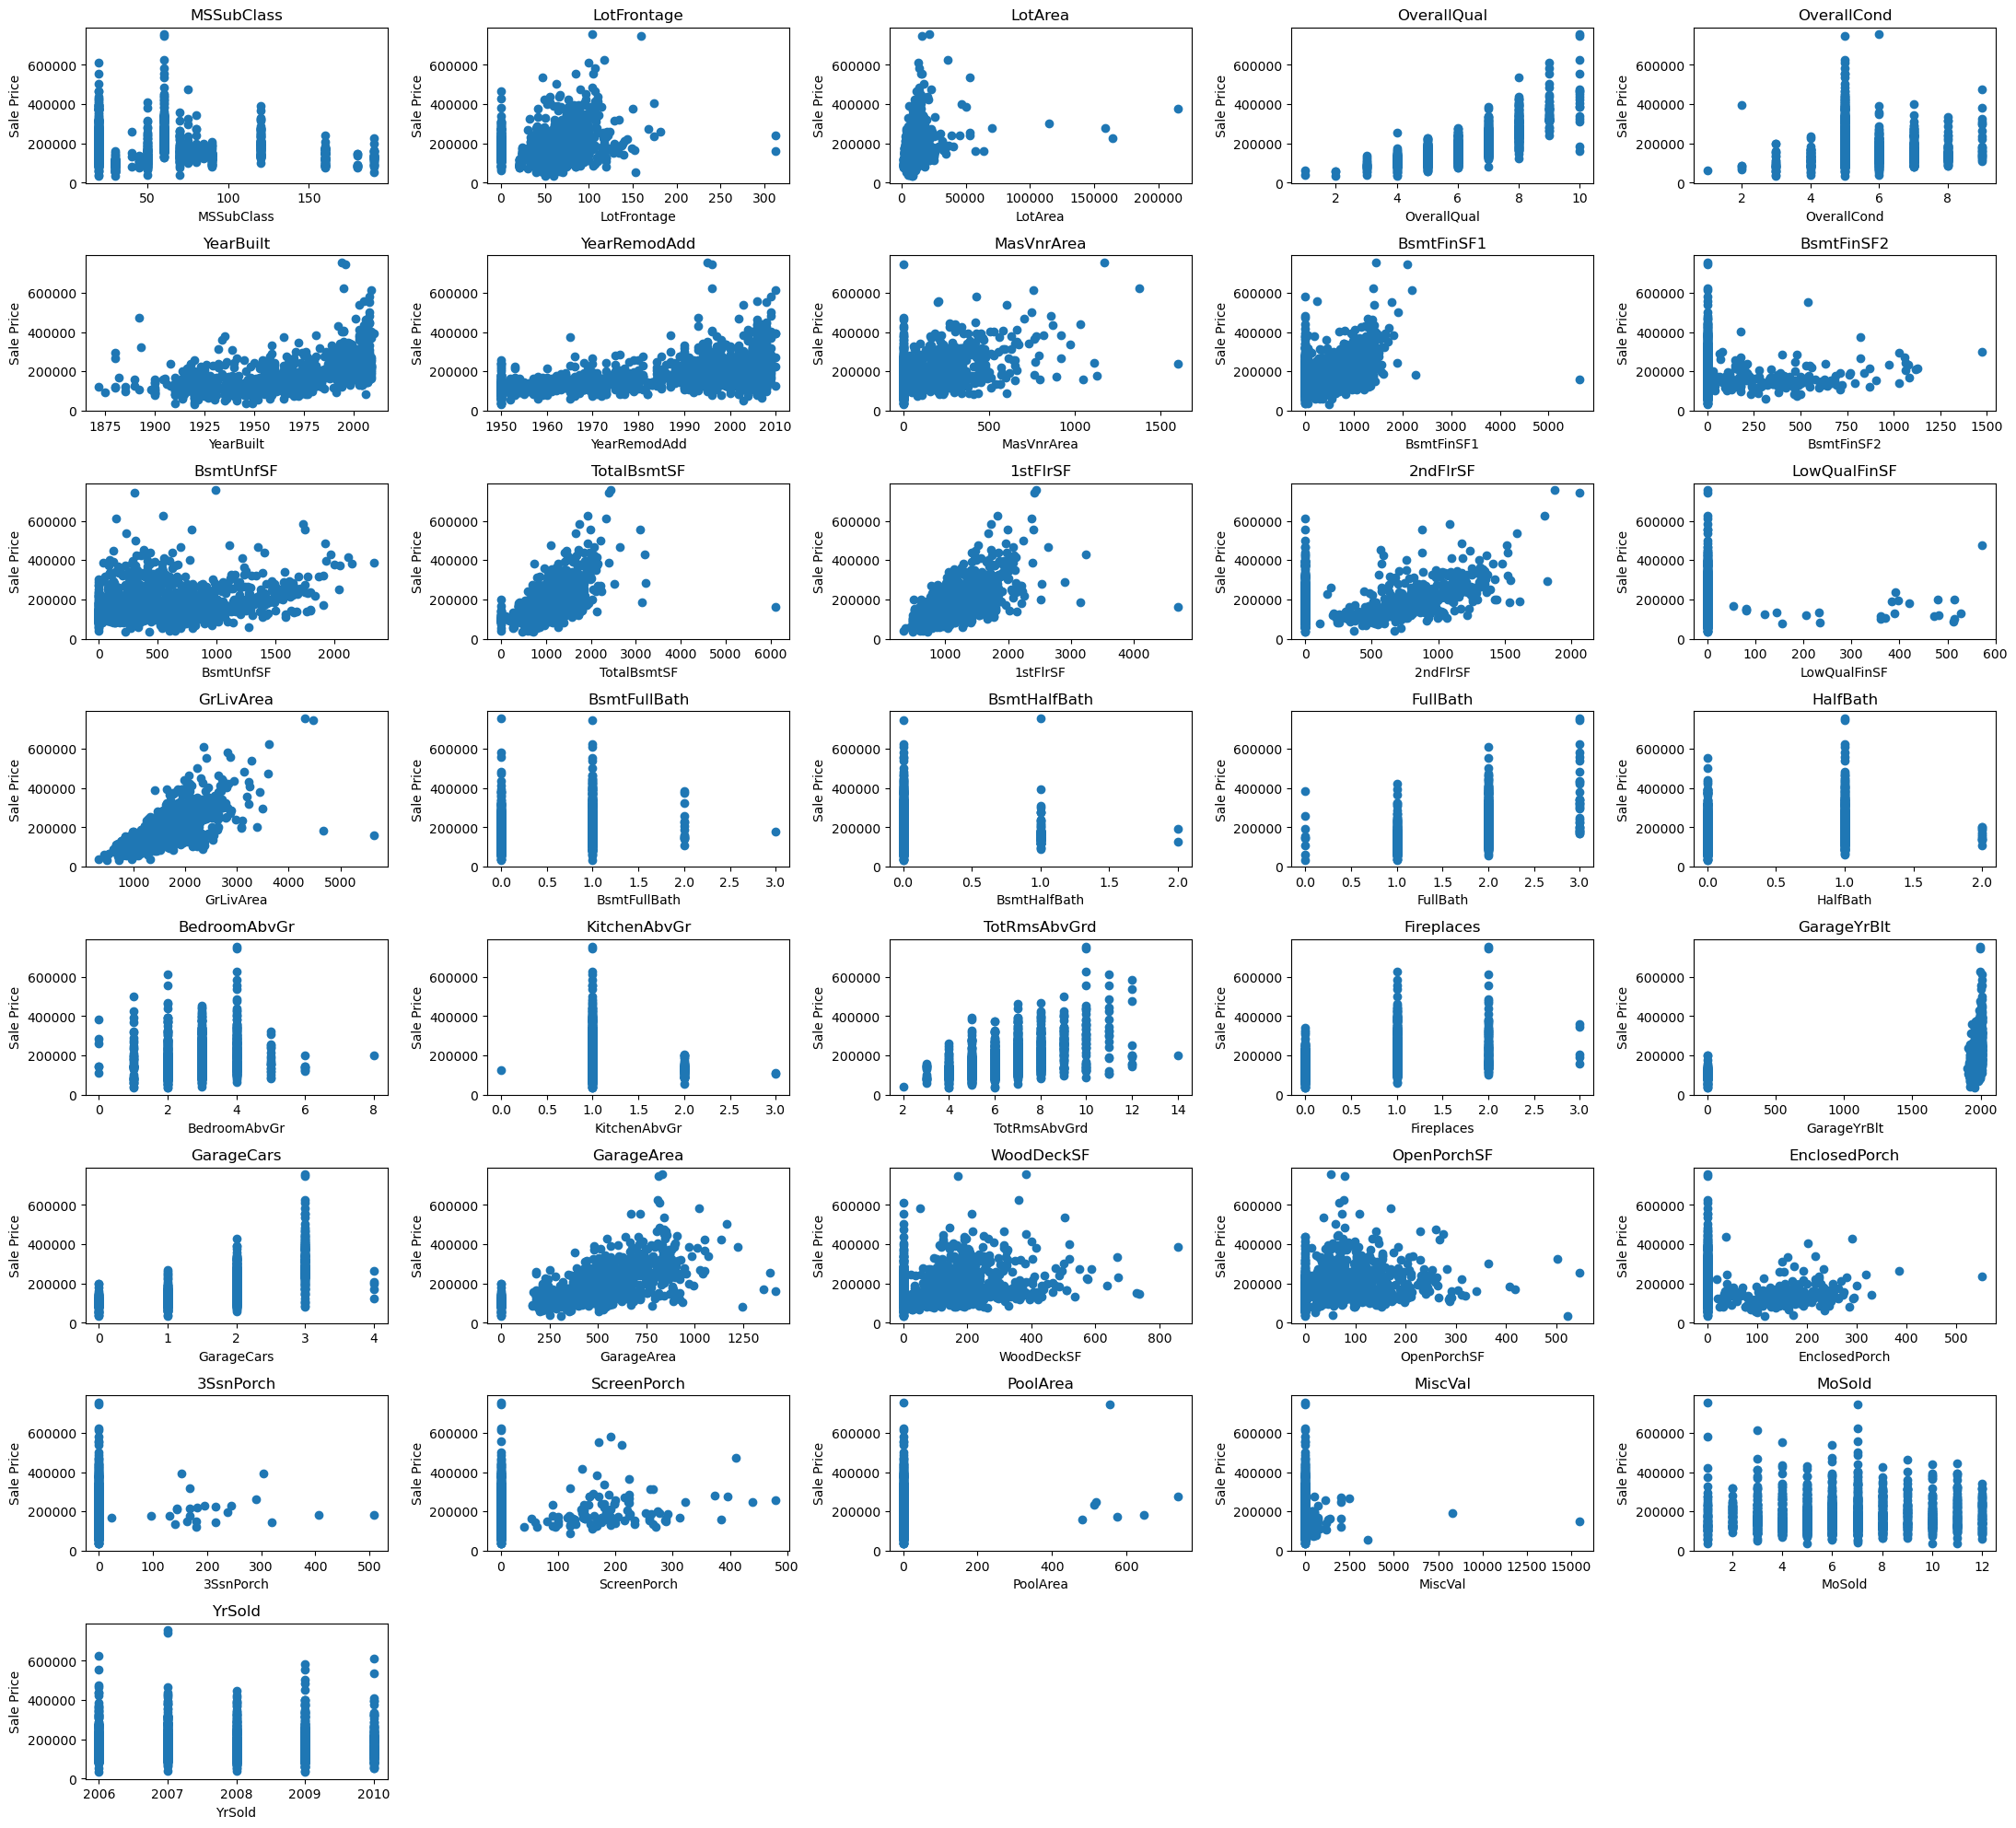

In [386]:
plt.figure(figsize = (22,22))
for i,col in enumerate(numeric_features):
    plt.subplot(9,5,i+1)
    
    x = numeric_features[col]
    y = train.SalePrice.values
    plt.scatter(x,y)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Sale Price")

    # Show the plot

plt.tight_layout()

## Cleaning missing values in numerical features

## Assaigning values to categories, where the highest value is given to the catergory with highest mean of SalePrice


In [387]:
# iterate over non-numeric columns
categorical_features['SalePrice']= train['SalePrice']
for column in categorical_features.columns:
    # calculate correlation between mean of "SalePrice" and each category in the column
    correlations = {
        category: categorical_features[categorical_features[column] == category]["SalePrice"].mean()
        for category in categorical_features[column].unique()
    }
    
    # sort categories by correlation in descending order
    sorted_correlations = {k: v for k, v in sorted(correlations.items(), key=lambda item: item[1], reverse=True)}
 
    # assign values to categories in descending order
    value = 1
    for category in sorted_correlations:
        categorical_features.loc[categorical_features[column] == category, column] = value
        value += 1

categorical_features.drop(['SalePrice'],inplace=True,axis=1)


## Testing RandomForest on numerical features
### What happens when we drop features that seem to predict very badly SalePrice?

### Which features get the lowest RMSE?


### Results: when dropping : 'YrSold','MoSold','MiscVal','PoolArea','ScreenPorch','3SsnPorch','EnclosedPorch','HalfBath','BsmtFullBath','BsmtHalfBath' We get the lowest RMSE: 31456 Max_depth =  12 

## BaseLine

In [437]:
y = train.SalePrice.values
X = numeric_features[ ["OverallQual"]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
mse = []
rang = range(1,20,1)
for i in rang:
    
    model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = model.predict(X_test)

    # calculate the mean squared error of the predictions
    mse.append(mean_squared_error(y_test, y_pred,squared=False))


print("RMSE:", int(np.min(mse)),", Max_depth = ", rang[np.argmin(mse)], ", Col = ",col)

RMSE: 47811 , Max_depth =  4 , Col =  LotFrontage


In [439]:
### 20 MIN LOOP CHECKING WHICH FEATURES ARE BEST
y = train.SalePrice.values
X = numeric_features[ ["OverallQual"]].copy()
rang = range(1,15,1)
good_feautres = []
for col in numeric_features.columns:
    if col != "OverallQual":
        X[col] = numeric_features[col]
        mse = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        for i in rang:
            
            model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

            # fit the model on the training data
            model.fit(X_train, y_train)

            # make predictions on the test data
            y_pred = model.predict(X_test)

            # calculate the mean squared error of the predictions
            mse.append(mean_squared_error(y_test, y_pred,squared=False))

        min_mse = int(np.min(mse))
        if min_mse < 47800:
            good_feautres.append(col)
        print("RMSE:", int(np.min(mse)),", Max_depth = ", rang[np.argmin(mse)], ", Col = ",col)
        X.drop(col,axis=1,inplace=True)




RMSE: 46305 , Max_depth =  4 , Col =  MSSubClass
RMSE: 48402 , Max_depth =  4 , Col =  LotFrontage
RMSE: 43309 , Max_depth =  6 , Col =  LotArea
RMSE: 49603 , Max_depth =  3 , Col =  OverallCond
RMSE: 45969 , Max_depth =  4 , Col =  YearBuilt
RMSE: 43451 , Max_depth =  6 , Col =  YearRemodAdd
RMSE: 46579 , Max_depth =  10 , Col =  MasVnrArea
RMSE: 44550 , Max_depth =  5 , Col =  BsmtFinSF1
RMSE: 47609 , Max_depth =  4 , Col =  BsmtFinSF2
RMSE: 48245 , Max_depth =  4 , Col =  BsmtUnfSF
RMSE: 44182 , Max_depth =  5 , Col =  TotalBsmtSF
RMSE: 42076 , Max_depth =  5 , Col =  1stFlrSF
RMSE: 41247 , Max_depth =  5 , Col =  2ndFlrSF
RMSE: 47822 , Max_depth =  4 , Col =  LowQualFinSF
RMSE: 36927 , Max_depth =  6 , Col =  GrLivArea
RMSE: 47444 , Max_depth =  3 , Col =  BsmtFullBath
RMSE: 48020 , Max_depth =  5 , Col =  BsmtHalfBath
RMSE: 43975 , Max_depth =  6 , Col =  FullBath
RMSE: 48054 , Max_depth =  6 , Col =  HalfBath
RMSE: 42018 , Max_depth =  11 , Col =  BedroomAbvGr
RMSE: 48005 , Max_d

## Checking RMSE using the important features

### RMSE: 33443 Max_depth =  13

In [441]:
y = train.SalePrice.values
X = numeric_features[good_feautres]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


for i in range(1,20):
    model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = model.predict(X_test)

    # calculate the mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred,squared=False)

    print("RMSE:", int(mse),"Max_depth = ",i)



RMSE: 63482 Max_depth =  1
RMSE: 51935 Max_depth =  2
RMSE: 43154 Max_depth =  3
RMSE: 38216 Max_depth =  4
RMSE: 35738 Max_depth =  5
RMSE: 35016 Max_depth =  6
RMSE: 34478 Max_depth =  7
RMSE: 33962 Max_depth =  8
RMSE: 33900 Max_depth =  9
RMSE: 33590 Max_depth =  10
RMSE: 33771 Max_depth =  11
RMSE: 33690 Max_depth =  12
RMSE: 33443 Max_depth =  13
RMSE: 33659 Max_depth =  14
RMSE: 33765 Max_depth =  15
RMSE: 33832 Max_depth =  16
RMSE: 33544 Max_depth =  17
RMSE: 33882 Max_depth =  18
RMSE: 33809 Max_depth =  19


## Trying to add some catergorical features to see if we improve RMSE

### IMPORTANT FEATURES FOUND ['Neighborhood','Alley','Street','BldgType']

#### RMSE: 29009 Max_depth =  14


In [ ]:
#### 20 MIN LOOP CHECKING WHICH FEATURES ARE BEST
# rang = range(7,20,1)
# for col in categorical_features.columns[15:]:
#     X[col] = categorical_features[col]
#     mse = []

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     for i in rang:
        
#         model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#         # fit the model on the training data
#         model.fit(X_train, y_train)

#         # make predictions on the test data
#         y_pred = model.predict(X_test)

#         # calculate the mean squared error of the predictions
#         mse.append(mean_squared_error(y_test, y_pred,squared=False))


#     print("RMSE:", int(np.min(mse)),", Max_depth = ", rang[np.argmin(mse)], ", Col = ",col)
#     X.drop(col,axis=1,inplace=True)

In [443]:
y = train.SalePrice.values
X = numeric_features[good_feautres].copy()
X[['Neighborhood','Alley','Street','BldgType']] = categorical_features[['Neighborhood','Alley','Street','BldgType']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


for i in range(1,20):
    model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = model.predict(X_test)

    # calculate the mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred,squared=False)

    print("RMSE:", int(mse),"Max_depth = ",i)



RMSE: 60870 Max_depth =  1
RMSE: 50182 Max_depth =  2
RMSE: 41773 Max_depth =  3
RMSE: 36453 Max_depth =  4
RMSE: 34031 Max_depth =  5
RMSE: 32620 Max_depth =  6
RMSE: 31869 Max_depth =  7
RMSE: 31581 Max_depth =  8
RMSE: 31534 Max_depth =  9
RMSE: 31480 Max_depth =  10
RMSE: 31047 Max_depth =  11
RMSE: 31093 Max_depth =  12
RMSE: 31347 Max_depth =  13
RMSE: 31129 Max_depth =  14
RMSE: 31045 Max_depth =  15
RMSE: 31243 Max_depth =  16
RMSE: 31319 Max_depth =  17
RMSE: 31186 Max_depth =  18
RMSE: 31165 Max_depth =  19


## Does one hot encoding improve results?

#### Doesn't seem to change anything

In [398]:
y = train.SalePrice.values
X = numeric_features.drop(['YrSold','MoSold','MiscVal','PoolArea','ScreenPorch','3SsnPorch','EnclosedPorch','HalfBath','BsmtFullBath','BsmtHalfBath',"MasVnrArea"],axis=1)
X[['Neighborhood','Alley','Street','BldgType']] = categorical_features[['Neighborhood','Alley','Street','BldgType']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

col = 'BldgType'
X[[col]] = train[[col]]
X = pd.get_dummies(X, columns=[col])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



for i in range(10,18):
    model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = model.predict(X_test)

    # calculate the mean squared error of the predictions
    mse = mean_squared_error(y_test, y_pred,squared=False)

    print("RMSE:", int(mse),"Max_depth = ",i)

RMSE: 29351 Max_depth =  10
RMSE: 29161 Max_depth =  11
RMSE: 29247 Max_depth =  12
RMSE: 29122 Max_depth =  13
RMSE: 29282 Max_depth =  14
RMSE: 29130 Max_depth =  15
RMSE: 29132 Max_depth =  16
RMSE: 29152 Max_depth =  17


#### Try to split BldgType to 2 categories and see what happens to RMSE

### Trying Regression for feature importance 

array([[0., 0., 0., ..., 0., 0., 0.]])

In [465]:
from sklearn.linear_model import Lasso

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
X = pd.concat([numeric_features,categorical_features],axis=1)
scaler = StandardScaler()
y = train.SalePrice.values.reshape(-1, 1)
scaler.fit(y)
y = scaler.transform(y)
# Fit the scaler to the data
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
feature_names = X.columns

# Get the coefficients from the fitted model
coefficients = reg.coef_

# Combine the feature names and coefficients into a dataframe
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Print the dataframe
print(coeff_df)

          Feature  Coefficient
0      MSSubClass    -0.000000
1     LotFrontage     0.000000
2         LotArea     0.000000
3     OverallQual     0.228471
4     OverallCond    -0.000000
5       YearBuilt     0.000000
6    YearRemodAdd     0.000000
7      MasVnrArea     0.000000
8      BsmtFinSF1     0.000000
9      BsmtFinSF2    -0.000000
10      BsmtUnfSF     0.000000
11    TotalBsmtSF     0.000000
12       1stFlrSF     0.000000
13       2ndFlrSF     0.000000
14   LowQualFinSF    -0.000000
15      GrLivArea     0.060043
16   BsmtFullBath     0.000000
17   BsmtHalfBath     0.000000
18       FullBath     0.000000
19       HalfBath     0.000000
20   BedroomAbvGr     0.000000
21   KitchenAbvGr    -0.000000
22   TotRmsAbvGrd     0.000000
23     Fireplaces     0.000000
24    GarageYrBlt     0.000000
25     GarageCars     0.000000
26     GarageArea     0.000000
27     WoodDeckSF     0.000000
28    OpenPorchSF     0.000000
29  EnclosedPorch    -0.000000
30      3SsnPorch     0.000000
31    Sc

In [452]:
X

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       0.235294     0.207668  0.033420     0.666667        0.500   0.949275   
1       0.000000     0.255591  0.038795     0.555556        0.875   0.753623   
2       0.235294     0.217252  0.046507     0.666667        0.500   0.934783   
3       0.294118     0.191693  0.038561     0.666667        0.500   0.311594   
4       0.235294     0.268371  0.060576     0.777778        0.500   0.927536   
5       0.176471     0.271565  0.059899     0.444444        0.500   0.876812   
6       0.000000     0.239617  0.041057     0.777778        0.500   0.956522   
7       0.235294     0.000000  0.042450     0.666667        0.625   0.731884   
8       0.176471     0.162939  0.022529     0.666667        0.500   0.427536   
9       1.000000     0.159744  0.028605     0.444444        0.625   0.485507   
10      0.000000     0.223642  0.046274     0.444444        0.500   0.673913   
11      0.235294     0.271565  0.049658     0.888889        0.500   0.963768   
12      0.000000     0.000000  0.054537     0.444444        0.625   0.652174   
13      0.000000     0.290735  0.043712     0.666667        0.500   0.971014   
14      0.000000     0.000000  0.044965     0.555556        0.500   0.637681   
15      0.147059     0.162939  0.022529     0.666667        0.875   0.413043   
16      0.000000     0.000000  0.046465     0.555556        0.750   0.710145   
17      0.411765     0.230032  0.044362     0.333333        0.500   0.688406   
18      0.000000     0.210863  0.057935     0.444444        0.500   0.956522   
19      0.000000     0.223642  0.029260     0.444444        0.625   0.623188   
20      0.235294     0.322684  0.060366     0.777778        0.500   0.963768   
21      0.147059     0.182109  0.028741     0.666667        0.750   0.420290   
22      0.000000     0.239617  0.039459     0.777778        0.500   0.942029   
23      0.588235     0.140575  0.013667     0.444444        0.750   0.753623   
24      0.000000     0.000000  0.032466     0.444444        0.875   0.695652   
25      0.000000     0.351438  0.060436     0.777778        0.500   0.978261   
26      0.000000     0.191693  0.027577     0.444444        0.750   0.572464   
27      0.000000     0.313099  0.047573     0.777778        0.500   0.978261   
28      0.000000     0.150160  0.070210     0.444444        0.625   0.615942   
29      0.058824     0.191693  0.023483     0.333333        0.625   0.398551   
30      0.294118     0.159744  0.033654     0.333333        0.375   0.347826   
31      0.000000     0.000000  0.033859     0.444444        0.625   0.681159   
32      0.000000     0.271565  0.045568     0.777778        0.500   0.978261   
33      0.000000     0.223642  0.043245     0.444444        0.500   0.630435   
34      0.588235     0.191693  0.028105     0.888889        0.500   0.963768   
35      0.235294     0.345048  0.056641     0.777778        0.500   0.956522   
36      0.000000     0.357827  0.044680     0.444444        0.500   0.884058   
37      0.000000     0.236422  0.033803     0.444444        0.625   0.594203   
38      0.000000     0.217252  0.030952     0.444444        0.750   0.586957   
39      0.411765     0.207668  0.022155     0.333333        0.500   0.601449   
40      0.000000     0.268371  0.034392     0.555556        0.500   0.673913   
41      0.000000     0.367412  0.072939     0.444444        0.625   0.630435   
42      0.382353     0.000000  0.036832     0.444444        0.750   0.804348   
43      0.000000     0.000000  0.036925     0.444444        0.625   0.746377   
44      0.000000     0.223642  0.031059     0.444444        0.625   0.630435   
45      0.588235     0.194888  0.029718     0.888889        0.500   0.963768   
46      0.176471     0.153355  0.053855     0.666667        0.500   0.949275   
47      0.000000     0.268371  0.045787     0.777778        0.500   0.971014   
48      1.000000     0.105431  0.014751     0.333333        0.500   0.347826   
49    

## Lets look where is the model most wrong and why

In [ ]:
model = RandomForestRegressor(n_estimators=500,max_depth=18,random_state=0)
# make predictions on the test data
model.fit(X_train,y_train)

# calculate the mean squared error of the predictions



RandomForestRegressor(max_depth=18, n_estimators=500, random_state=0)

In [ ]:
y_pred = np.round(np.sqrt((model.predict(X) - y)**2),3)
X["RMSE"] = y_pred
X.sort_values(by='RMSE', ascending=False, inplace=True)

In [401]:
train.loc[X[0:25].index].sort_values(by='SalePrice', ascending=False, inplace=False)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
11          60       RL         85.0    11924   Pave   NaN      IR1   
20          60       RL        101.0    14215   Pave   NaN      IR1   
6           20       RL         75.0    10084   Pave   NaN      Reg   
13          20       RL         91.0    10652   Pave   NaN      IR1   
4           60       RL         84.0    14260   Pave   NaN      IR1   
22          20       RL         75.0     9742   Pave   NaN      Reg   
2           60       RL         68.0    11250   Pave   NaN      IR1   
0           60       RL         65.0     8450   Pave   NaN      Reg   
7           60       RL          0.0    10382   Pave   NaN      IR1   
1           20       RL         80.0     9600   Pave   NaN      Reg   
18          20       RL         66.0    13695   Pave   NaN      Reg   
14          20       RL          0.0    10920   Pave   NaN      IR1   
24          20       RL          0.0     8246   Pave   NaN      IR1   
16          20       RL          0.0    11241   Pave   NaN      IR1   
12          20       RL          0.0    12968   Pave   NaN      IR2   
5           50       RL         85.0    14115   Pave   NaN      IR1   
3           70       RL         60.0     9550   Pave   NaN      IR1   
21          45       RM         57.0     7449   Pave  Grvl      Reg   
19          20       RL         70.0     7560   Pave   NaN      Reg   
15          45       RM         51.0     6120   Pave   NaN      Reg   
8           50       RM         51.0     6120   Pave   NaN      Reg   
23         120       RM         44.0     4224   Pave   NaN      Reg   
10          20       RL         70.0    11200   Pave   NaN      Reg   
9          190       RL         50.0     7420   Pave   NaN      Reg   
17          90       RL         72.0    10791   Pave   NaN      Reg   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
11         Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
20         Lvl    AllPub    Corner       Gtl      NridgHt       Norm   
6          Lvl    AllPub    Inside       Gtl      Somerst       Norm   
13         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
22         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
0          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
7          Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
1          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
18         Lvl    AllPub    Inside       Gtl      SawyerW       RRAe   
14         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
24         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   
16         Lvl    AllPub   CulDSac       Gtl        NAmes       Norm   
12         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   
5          Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
3          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
21         Bnk    AllPub    Inside       Gtl       IDOTRR       Norm   
19         Lvl    AllPub    Inside       Gtl        NAmes       Norm   
15         Lvl    AllPub    Corner       Gtl      BrkSide       Norm   
8          Lvl    AllPub    Inside       Gtl      OldTown     Artery   
23         Lvl    AllPub    Inside       Gtl      MeadowV       Norm   
10         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   
9          Lvl    AllPub    Corner       Gtl      BrkSide     Artery   
17         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
11       Norm     1Fam     2Story            9            5       2005   
20       Norm     1Fam     2Story            8            5       2005   
6        Norm     1Fam     1Story            8            5   